# Lista 2

## `Questão 1`
Considere o conjunto de dados disponível em **`breastcancer.csv`**, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset.

A) Considerando uma validação cruzada em 10 folds, avalie modelos de classicação binária nos dados em questão. Para tanto, use as abordagens
abaixo:  

- **Regressão logística** (treinado com GD ou SGD);
- **Análise do discriminante Gaussiano**;
- **Naive Bayes Gaussiano**.
  
B) Para cada modelo criado, reporte valor médio e desvio padrão da **acurácia global** e da **acurácia por classe**


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
breastcancer_data = np.loadtxt('./breastcancer.csv', delimiter=',')
breastcancer_data.shape

(569, 31)

In [4]:
def add_independent_term_column(x: np.ndarray):
    return np.hstack((np.ones((x.shape[0], 1)), x))

In [6]:
x_breastcancer_data = breastcancer_data[:, :-1]
x_breastcancer_data = add_independent_term_column(x_breastcancer_data)
x_breastcancer_data.shape

(569, 31)

In [19]:
y_breastcancer_data = breastcancer_data[:, [-1]]
y_breastcancer_data.shape

(569, 1)

### `GD - Gradiente Descendente`

In [32]:
def mse_gd(x: np.ndarray, w: np.ndarray, y: np.ndarray):
    pred = x @ w
    error = y - pred
    mse = (error * error).mean()

    return mse

In [53]:
def log_func(value: float):
    return 1 / (1 + np.exp(-value))

In [68]:
# Gradiente descendente
def gd(x: np.ndarray, y: np.ndarray, alpha: float = 0.001, max_iterations: int = 100000, stopping_error: float = 1e-10):
    # Importando features e saídas
    X = x.copy()
    Y = y.copy()

    # Inicializando os pesos
    w_gd = np.zeros((X.shape[1], 1))

    errors_list_gd = np.empty((max_iterations, X.shape[0]))
    mse_list_gd = np.empty((max_iterations, 1))

    # Gradiente descendente
    for iter in range(max_iterations):

        # Calculando o erro
        pred_gd = X @ w_gd
        error_gd = Y - pred_gd
        
        w_gd[0] = w_gd[0] + alpha * error_gd.mean(axis = 0)
        w_gd[1:] = w_gd[1:] + alpha * (X[:,[1]].T @ error_gd) / X.shape[0]

        # Calculando o MSE e registrando o MSE e os Erros
        errors_list_gd[[iter], :] = error_gd.reshape(1, -1)
        mse_list_gd[iter] = mse_gd(X, w_gd, Y)

        # Parar caso o erro esteja abaixo do mínimo aceitável
        # if(mse_list_gd[iter] < stopping_error):
        #     print(f'GD encerrado precocemente pois os erros estão baixos o suficiente')
        #     break
    
    return w_gd, mse_gd(X, w_gd, y), errors_list_gd, mse_list_gd

In [72]:
# Gradiente descendente
def gd_log(x: np.ndarray, y: np.ndarray, alpha: float = 0.001, max_iterations: int = 100000, stopping_error: float = 1e-10):
    # Importando features e saídas
    X = x.copy()
    Y = y.copy()

    # Inicializando os pesos
    w_gd = np.zeros((X.shape[1], 1))

    errors_list_gd = np.empty((max_iterations, X.shape[0]))
    mse_list_gd = np.empty((max_iterations, 1))

    # Gradiente descendente
    for iter in range(max_iterations):

        # Calculando o erro
        pred_gd = log_func(X @ w_gd)
        error_gd = Y - pred_gd
        
        # w_gd[0] = w_gd[0] + alpha * error_gd.mean(axis = 0)
        # w_gd[1:] = w_gd[1:] + alpha * (X[:,1:].T @ error_gd) / X.shape[0]
        w_gd = w_gd + alpha * (X.T @ error_gd) / X.shape[0]

        # Calculando o MSE e registrando o MSE e os Erros
        errors_list_gd[[iter], :] = error_gd.reshape(1, -1)
        mse_list_gd[iter] = mse_gd(X, w_gd, Y)

        # Parar caso o erro esteja abaixo do mínimo aceitável
        # if(mse_list_gd[iter] < stopping_error):
        #     print(f'GD encerrado precocemente pois os erros estão baixos o suficiente')
        #     break
    
    return w_gd, mse_gd(X, w_gd, y), errors_list_gd, mse_list_gd

In [76]:
w_breastcancer_data_gd, mse_breastcancer_data_gd, errors_list_gd, mse_list_gd = gd_log(x_breastcancer_data, y_breastcancer_data, alpha=0.01, max_iterations=1000)

C:\Users\louis\AppData\Local\Temp\ipykernel_13904\745459150.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-value))


#### Parâmetros do modelo e **MSE (Erro Quadrático Médio)** final obitidos pelo algoritmo

In [77]:
w_breastcancer_data_gd

array([[-3.94697523e-01],
       [-3.00562586e+00],
       [-4.14765311e+00],
       [-1.74921033e+01],
       [-6.82551604e+00],
       [-2.79514274e-02],
       [ 1.15541778e-02],
       [ 5.39050119e-02],
       [ 2.29701823e-02],
       [-5.30821179e-02],
       [-2.21682064e-02],
       [-9.94393869e-03],
       [-2.71939629e-01],
       [ 9.55928003e-02],
       [ 7.78853526e+00],
       [-1.47343103e-03],
       [ 3.62500933e-03],
       [ 6.83345179e-03],
       [ 8.59361588e-04],
       [-4.59109362e-03],
       [-3.11276655e-04],
       [-3.18682672e+00],
       [-5.25532445e+00],
       [-1.77715282e+01],
       [ 1.01420085e+01],
       [-3.50279062e-02],
       [ 5.17793184e-02],
       [ 1.11121028e-01],
       [ 2.54979215e-02],
       [-7.28479524e-02],
       [-2.07330892e-02]])

In [78]:
mse_breastcancer_data_gd

9134551.737556431

#### Plote da curva de aprendizagem

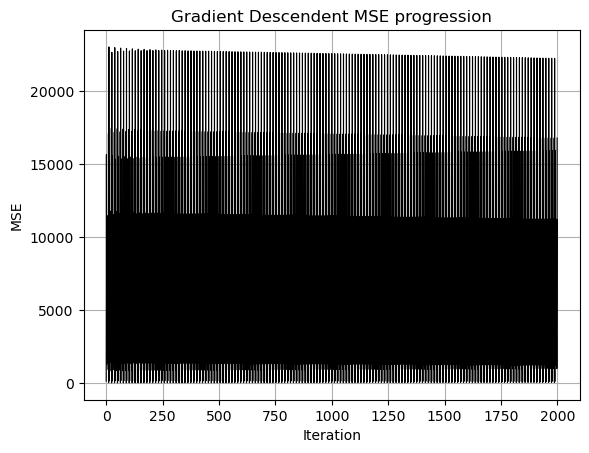

In [17]:
fig, ax = plt.subplots()

ax.set_title("Gradient Descendent MSE progression")
ax.set_ylabel("MSE")
ax.set_xlabel("Iteration")

ax.plot(np.arange(mse_list_gd.shape[0]), mse_list_gd, color='black', linewidth='0.8')
ax.grid(True)

plt.show()

### `SGD - Gradiente Descendente Estocástico`

In [19]:
# Gradiente descendente estocástico
def sgd(x: np.ndarray, y: np.ndarray, alpha: float = 0.001, max_epochs: int = 100, stopping_error: float = 1e-10):
    # Importando features e saídas
    X = x.copy()
    Y = y.copy()

    # Inicializando os pesos
    w_sgd = np.zeros((X.shape[1], 1))

    errors_list_sgd = np.empty((max_epochs * X.shape[0], X.shape[0]))
    mse_list_sgd = np.empty((max_epochs * X.shape[0], 1))

    # Gradiente descendente estocástico
    for epoch in range(max_epochs):
        # Permutando dados (entradas e saídas)
        XY = np.hstack((X, Y))
        XY = np.random.permutation(XY)
        X = XY[:, :-1]
        Y = XY[:, [-1]]

        for entry in range(X.shape[0]):
            # Calculando o erro
            pred_sgd = X[entry] @ w_sgd
            error_sgd = Y[entry] - pred_sgd
            
            w_sgd[0] = w_sgd[0] + alpha * error_sgd
            w_sgd[1:] = w_sgd[1:] + alpha * (X[entry,[1]].T * error_sgd)

            # Calculando o MSE e registrando o MSE e os Erros
            errors_list_sgd[[epoch * X.shape[0] + entry], :] = error_sgd.reshape(1, -1)
            mse_list_sgd[epoch * X.shape[0] + entry] = mse_gd(X, w_sgd, Y)

            # Parar caso o erro esteja abaixo do mínimo aceitável
            # if(mse < stopping_error):
            #     print(f'SGD encerrado precocemente pois os erros estão baixos o suficiente')
            #     break
    
    return w_sgd, mse_gd(X, w_sgd, y), errors_list_sgd, mse_list_sgd

In [20]:
w_breastcancer_data_sgd, mse_breastcancer_data_sgd, errors_list_sgd, mse_list_sgd = sgd(x_breastcancer_data, y_breastcancer_data, alpha= 0.01, max_epochs=60)

#### Parâmetros do modelo e **MSE (Erro Quadrático Médio)** final obitidos pelo algoritmo

In [21]:
w_breastcancer_data_sgd

array([[0.06673671],
       [1.57262774]])

In [22]:
mse_breastcancer_data_sgd

2.4159190202715966

#### Plote da reta resultante sobre os dados

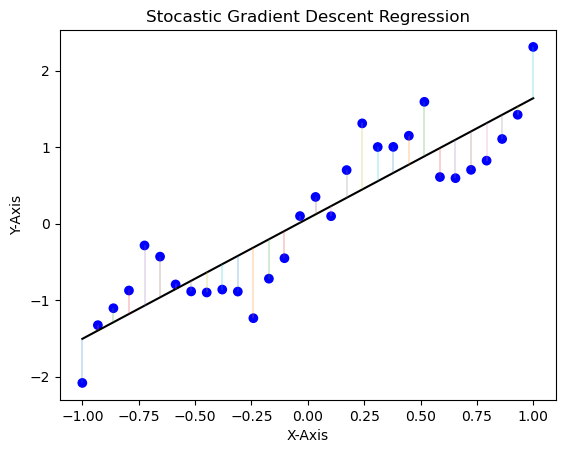

In [23]:
fig, ax = plt.subplots()

x_range_sgd = np.linspace(x_breastcancer_data.min(), x_breastcancer_data.max())
y_range_sgd = w_breastcancer_data_sgd[0] + w_breastcancer_data_sgd[1] * x_range_sgd

ax.set_title("Stocastic Gradient Descent Regression")
ax.set_ylabel("Y-Axis")
ax.set_xlabel("X-Axis")

ax.scatter(x_breastcancer_data[:, 1:], y_breastcancer_data, color='blue', marker='o', linestyle='')
ax.plot(x_range_sgd, y_range_sgd, color='black')

for i in range(len(x_breastcancer_data)):
    ax.plot([x_breastcancer_data[:, 1:][i], x_breastcancer_data[:, 1:][i]], [y_breastcancer_data[i], w_breastcancer_data_gd[0] + w_breastcancer_data_sgd[1] * x_breastcancer_data[:, 1:][i]], linewidth='0.3')

plt.show()

#### Plote da curva de aprendizagem

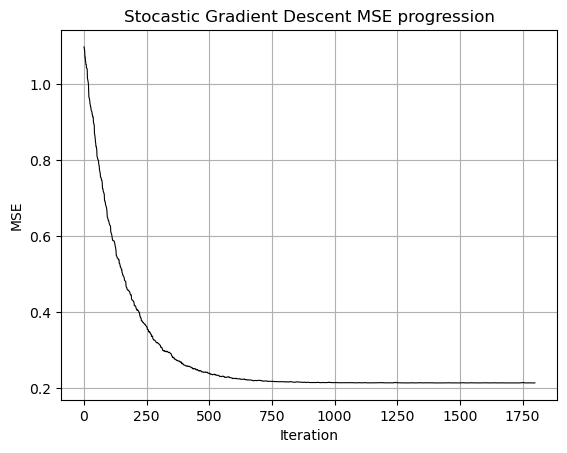

In [24]:
fig, ax = plt.subplots()

ax.set_title("Stocastic Gradient Descent MSE progression")
ax.set_ylabel("MSE")
ax.set_xlabel("Iteration")

ax.plot(np.arange(mse_list_sgd.shape[0]), mse_list_sgd, color='black', linewidth='0.8')
ax.grid(True)

plt.show()

## `Questão 2`
Considere o conjunto de dados disponível em california.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída.  
Os 8 atributos são usados na predição da mediana de preços de casas em distritos da Califórnia na década de 1990.

In [25]:
california_data = np.loadtxt('./california.csv', delimiter=',')
california_data.shape

(1000, 9)

In [26]:
x_california_data = california_data[:, :-1]
x_california_data.shape

(1000, 8)

In [27]:
y_california_data = california_data[:, [-1]]
y_california_data.shape

(1000, 1)

In [28]:
def normalize_dataset_minmax(x: np.ndarray, y: np.ndarray):
    x_columns_max = x.max(axis=0)
    ymax = y.max()
    
    x_columns_min = x.min(axis=0)
    ymin = y.min()

    x = (x - x_columns_min) / (x_columns_max - x_columns_min)
    y = (y - ymin) / (ymax - ymin)

    # Valores necessários para a desnormalização
    xscale_tuple = (x_columns_max - x_columns_min, x_columns_min)
    yscale_tuple = (ymax - ymin, ymin)
    
    return x, y, xscale_tuple, yscale_tuple

def denormalize_dataset_minmax(x: np.ndarray, y: np.ndarray, xscale: Tuple[np.ndarray, np.ndarray], yscale: Tuple[float, float]):
    y = y * yscale[0] + yscale[1]
    x = x * xscale[0] + xscale[1]

    return x, y

def normalize_dataset_zscore(x: np.ndarray, y: np.ndarray):
    return 

def denormalize_dataset_zscore(x: np.ndarray, y: np.ndarray, scale: float):
    return 

In [29]:
def polify(x: np.ndarray, degrees: int):
    X = x.copy()

    for degree in range(2, degrees + 1):
        X_next_degree = x ** (degree)
        X = np.hstack((X, X_next_degree))

    return X

In [30]:
def split_train_test(x: np.ndarray, y: np.ndarray, split: float):
    # Checar valor do split
    if not (0.0 <= split <= 1.0):
        raise ValueError("O valor de split deve ser de 0 à 1")
    
    # Permuta os dados
    xy = np.random.permutation(np.hstack((x, y)))

    # Divide os dados entre treino e teste
    split_index = int(np.rint(xy.shape[0] * split))
    train = xy[:split_index, :]
    test = xy[split_index:, :]

    return train, test

In [31]:
def kfold_crossvalidation():
    return

def loo_crossvalidation():
    return kfold_crossvalidation()

In [32]:
for e in range(1, 14):
    x_california_poly_data = polify(x_california_data, e)

    x_california_train_data, x_california_test_data = split_train_test(x_california_poly_data, y_california_data, 0.8)

    x_california_poly_train_data = add_independent_term_column(x_california_train_data[:, :-1])
    y_california_poly_train_data = x_california_train_data[:, [-1]]

    w_california_poly_data_ols, mse_california_data_ols = ols(x_california_poly_train_data, y_california_poly_train_data)

    print(f"MSE OLS - Polinômio de grau {e:02}: {mse_california_data_ols}")

MSE OLS - Polinômio de grau 01: 0.45597215629744864
MSE OLS - Polinômio de grau 02: 0.3899240348661593
MSE OLS - Polinômio de grau 03: 0.38998231928872884
MSE OLS - Polinômio de grau 04: 0.36462986116940455
MSE OLS - Polinômio de grau 05: 1.5760531795650232
MSE OLS - Polinômio de grau 06: 0.3641995677718611
MSE OLS - Polinômio de grau 07: 0.3580035303910964
MSE OLS - Polinômio de grau 08: 0.34716428049601594
MSE OLS - Polinômio de grau 09: 0.3625440623835709
MSE OLS - Polinômio de grau 10: 0.370593211559068
MSE OLS - Polinômio de grau 11: 0.3871390578579385
MSE OLS - Polinômio de grau 12: 0.41768178554651364
MSE OLS - Polinômio de grau 13: 0.3615144583754144


In [35]:
rmse_california_train = []
rmse_california_test = []

for e in range(1, 14):
    x_california_poly_data = polify(x_california_data, e)

    california_train_data, california_test_data = split_train_test(x_california_poly_data, y_california_data, 0.8)

    y_california_train_data = california_train_data[:, [-1]]
    x_california_test_data = add_independent_term_column(california_test_data[:, :-1])
    y_california_test_data = california_test_data[:, [-1]]

    x_california_train_data_normalized, y_california_train_data_normalized, xscale_california, yscale_california = normalize_dataset_minmax(x_california_train_data, y_california_train_data)
    x_california_train_data_normalized = add_independent_term_column(x_california_train_data_normalized)

    w_california_poly_data_ols, mse_california_data_ols = ols(x_california_train_data_normalized, y_california_train_data_normalized)

    rmse_california_train.append(np.sqrt(mse_california_data_ols))
    print(f"RMSE OLS - Polinômio de grau {e:02}: {mse_california_data_ols}")

RMSE OLS - Polinômio de grau 01: 0.05689536762585117
RMSE OLS - Polinômio de grau 02: 0.05251189024486484
RMSE OLS - Polinômio de grau 03: 0.05181929492684268
RMSE OLS - Polinômio de grau 04: 0.054530203987410035
RMSE OLS - Polinômio de grau 05: 0.05429554318621056
RMSE OLS - Polinômio de grau 06: 0.055730729330896206
RMSE OLS - Polinômio de grau 07: 0.05768318620621054
RMSE OLS - Polinômio de grau 08: 0.055447985085400636
RMSE OLS - Polinômio de grau 09: 0.056071103217787854
RMSE OLS - Polinômio de grau 10: 0.053866388695649865
RMSE OLS - Polinômio de grau 11: 0.053484026973178785
RMSE OLS - Polinômio de grau 12: 0.05782508413295501
RMSE OLS - Polinômio de grau 13: 0.053511718521713644
